1. Basic dataset preparation
2. PCA
   - a.) PCA no scaling vs. PCA after scaling
          Visualizing the difference by color
          Inspecting the structure of molecules in certain destinct PC ranges
   - b.) Choosing the number of Principle components
   - c.) Interpretation of principle components
3. tSNE
4. (PacMap)

In [ ]:
# Include flow chart of what we are showing

## Environment setup

Loading auxiliary files, install necessary Python libraries, and download the dataset

In [2]:
# This will replace the data dowloading and all pip installations
# ! bash setup.sh

shred: qm7.dat: failed to open for writing: No such file or directory
--2023-07-23 13:46:56--  http://quantum-machine.org/data/qm7.mat
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17884280 (17M)
Saving to: ‘qm7.mat’

qm7.mat             100%[===================>]  17.06M  72.4MB/s    in 0.2s    

2023-07-23 13:46:56 (72.4 MB/s) - ‘qm7.mat’ saved [17884280/17884280]

shred: molecule_visualizer.py: failed to open for writing: No such file or directory
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2952 sha256=99cfee93db56afd5b4fea9dc6649c750c177023f9e04be213f51bb559735f498
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [3]:
# Math libraries
import numpy as np

# Data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [4]:
# Import function for visualization of molecules from file (Molecule_viewer.py can be found in the GitHub)
from Molecule_viewer import view_molecule

## Loading the data

In this best practices tutorial, we will use the [QM7 dataset](http://quantum-machine.org/datasets/) as a toy example to discuss and demonstrate the benefits of dimensionality reduction techniques in exploring the chemical space. The dataset comprises 7165 organic molecules with diverse sizes (up to 23 atoms) and chemical compositions, featuring heavy elements such as C, N, O, and S. In addition to the three-dimensional molecular strucutres available either as standard Cartesian coordinates or in the Coulomb matrix representation, the QM7 dataset also provides atomization energies for each compound calculated using Density Functional Theory (DFT).

In [8]:
import scipy.io

# The qm7 dataset will be load as a python dictionary
qm7_data = scipy.io.loadmat('qm7.mat')

print(f"Data type : {type(qm7_data)}")

Data type : <class 'dict'>


The data is loaded as a Python dictionary containing the following keys:

*   **X**: coulomb matrices
*   **R**: cartesian coordinate (unit: Bohr)
*   **Z**: atomic charges
*   **T**: atomization energies (unit: kcal/mol)
*   **P**: cross-validation splits as used in [Montavon et al. NIPS, 2012]

In [ ]:
for k in qm7_data.keys():
    if "_" not in k:
        print("{} ---> {}".format(k,qm7_data[k].shape))
    else:
        print(k, qm7_data[k])

__header__ b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Feb 18 17:12:08 2013'
__version__ 1.0
__globals__ []
X ---> (7165, 23, 23)
R ---> (7165, 23, 3)
Z ---> (7165, 23)
T ---> (1, 7165)
P ---> (5, 1433)


Let us make a quick sanity check for the first entry of the dataset, which corresponds to the methane molecule.

In [ ]:
print("Atomic charges:")
print(qm7_data['Z'][0])
print(" ")
print("Cartesian coordinates:")
print(qm7_data['R'][0])

Atomic charges:
[6. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 
Cartesian coordinates:
[[ 1.886438   -0.00464873 -0.00823921]
 [ 3.9499245  -0.00459203  0.00782347]
 [ 1.1976895   1.9404842   0.00782347]
 [ 1.1849339  -0.99726516  1.6593875 ]
 [ 1.2119948  -0.9589793  -1.710958  ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0. 

Note that, in order to maintain consistent array sizes across the entire dataset, molecules with fewer than the maximum number of atoms (23) will be zero-padded in their corresponding arrays. While this step ensures uniformity, it is crucial to carefully consider the zero-padding feature before applying any dimension reduction (DR) analysis, since a DR algorithm might merely learn to distinguish molecules based on their sizes or unintentionally segment the dataset into subsets of molecules with equal sizes, thereby failing to capture meaningful chemical patterns underlying the data distribution. To avoid this issue, we will perform the DR analysis on the 15-atoms subset of the QM7 dataset.  

In [ ]:
nonzeros = np.count_nonzero(qm7_data['Z'],axis=1)
# Select molecules with only 15 atoms
n_max_atoms = 15
idx = np.where(nonzeros == n_max_atoms)
qm7_data['X'] = qm7_data['X'][idx][:,:n_max_atoms,:n_max_atoms]
qm7_data['R'] = qm7_data['R'][idx][:,:n_max_atoms]
qm7_data['Z'] = qm7_data['Z'][idx][:,:n_max_atoms]
qm7_data['T'] = qm7_data['T'].flatten()[idx]

## Building the Coulomb matrix dataset for the analysis

In [ ]:
print("Coulomb matrix:")
print(qm7_data['X'][0])

Coulomb matrix:
[[73.51669    17.79188    10.574583   10.609484    6.72828     4.352822
   2.0783362   1.5839126   1.6360577   1.5685378   1.2611265   1.013529
   1.6256311   1.0404118   0.9301662 ]
 [17.79188    36.858105   12.444374   12.511555    7.4616017   1.6210611
   2.899028    1.4651774   1.4753506   1.4622504   1.4564468   1.1054873
   1.4680866   1.1392418   0.90926206]
 [10.574583   12.444374   36.858105    7.4560533  12.53489     1.2365621
   1.4679073   2.8932884   2.892906    1.1357094   1.1043904   1.4606544
   0.9081943   1.4643822   1.4723637 ]
 [10.609484   12.511555    7.4560533  36.858105    6.0957327   1.2397863
   1.4769639   1.133233    0.9116201   2.897561    2.9032035   1.1057171
   2.8976808   0.9178894   0.76837534]
 [ 6.72828     7.4616017  12.53489     6.0957327  36.858105    0.7923406
   1.13689     1.4751805   1.4800829   0.914806    1.1048201   2.9026
   0.76742256  2.9010375   2.900114  ]
 [ 4.352822    1.6210611   1.2365621   1.2397863   0.7923406   0

In [ ]:
n_samples, cm_rows, cm_cols = qm7_data['X'].shape
# Transform the original tensor shape of the CM descriptor, qm7['X'], into a 2D matrix
qm7_cm = qm7_data['X'].reshape(-1, cm_rows * cm_cols)
qm7_cm.shape

(1219, 225)

In [ ]:
df_qm7_cm = pd.DataFrame(qm7_cm)
df_qm7_cm.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
1167,53.358707,11.720174,16.192354,16.196695,10.220803,8.869435,8.871946,3.668114,1.145161,1.406760,...,0.550140,2.899823,0.137334,0.187578,0.087681,0.298703,0.298687,0.083588,0.083576,0.5
1072,73.516693,6.397538,6.898983,10.596918,8.335988,6.749255,17.838615,1.645527,1.060674,2.066357,...,0.710950,1.628625,0.151873,0.117431,0.232113,0.143084,0.233919,0.085142,0.106195,0.5
1033,73.516693,8.250588,13.115013,20.681475,10.449057,5.818331,5.276914,1.628707,1.349254,1.461464,...,1.424494,2.931743,0.140049,0.132069,0.150463,0.169499,0.093409,0.289293,0.209915,0.5
33,53.358707,15.175128,8.661078,6.861054,15.231762,4.960001,1.701185,1.328701,1.075502,3.624879,...,2.923089,0.117771,0.129358,0.141763,0.094380,0.218511,0.084955,0.078970,0.284935,0.5
335,73.516693,18.380266,18.376541,10.724513,10.722662,10.665231,10.664989,1.436076,1.436426,1.306910,...,0.564661,2.929212,0.117657,0.167351,0.193115,0.106283,0.284544,0.088134,0.082026,0.5


# Principal Component Analysis (PCA)
## Without data standardization

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_qm7_cm)
X_reduced = pca.transform(df_qm7_cm)

To visualize the resulting principle components the first principle component can be plotted against the second one. It is possible to extract information about what information the principle components contain by coloring the data points according a certain value. In the following example the Data points are colored after atomization energy, chemical diversity and atomic charge of the heaviest atom in the molecule.

[8. 8. 8. ... 6. 6. 6.]


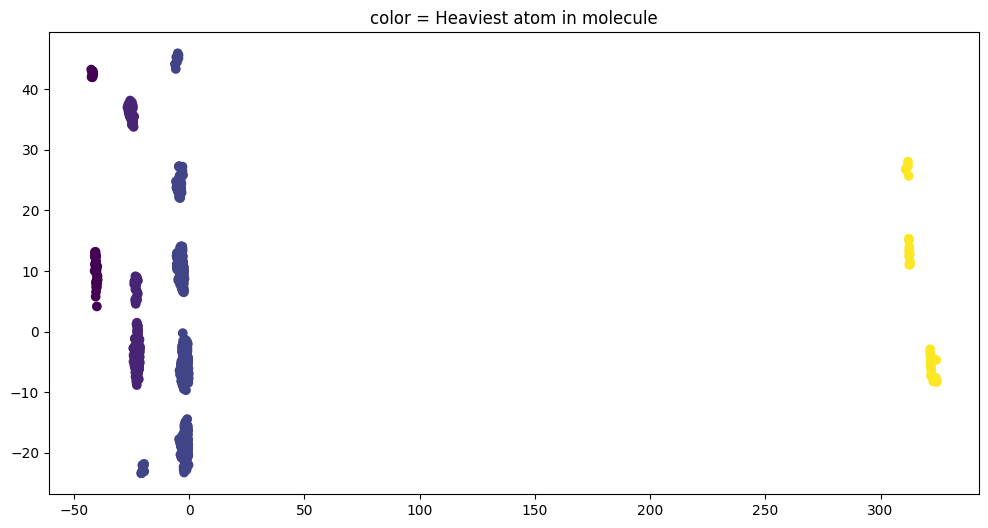

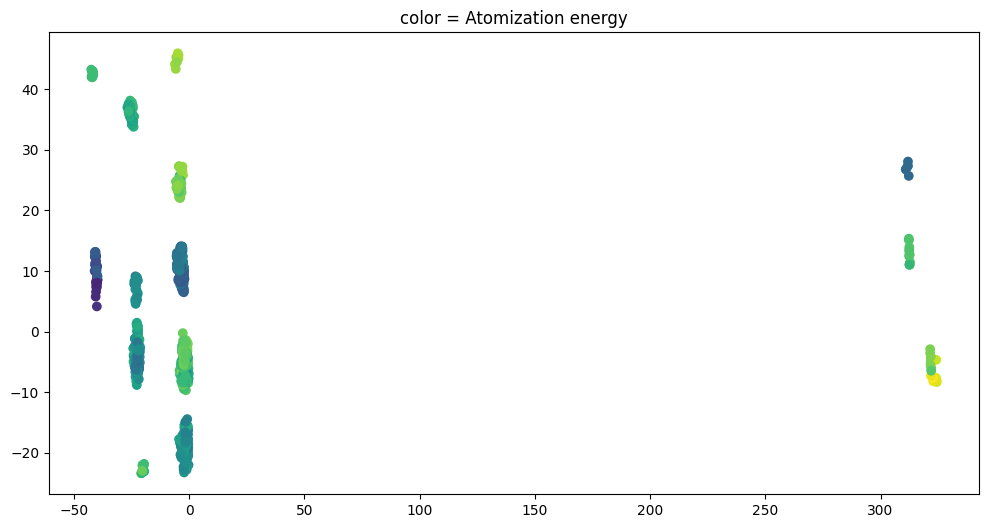

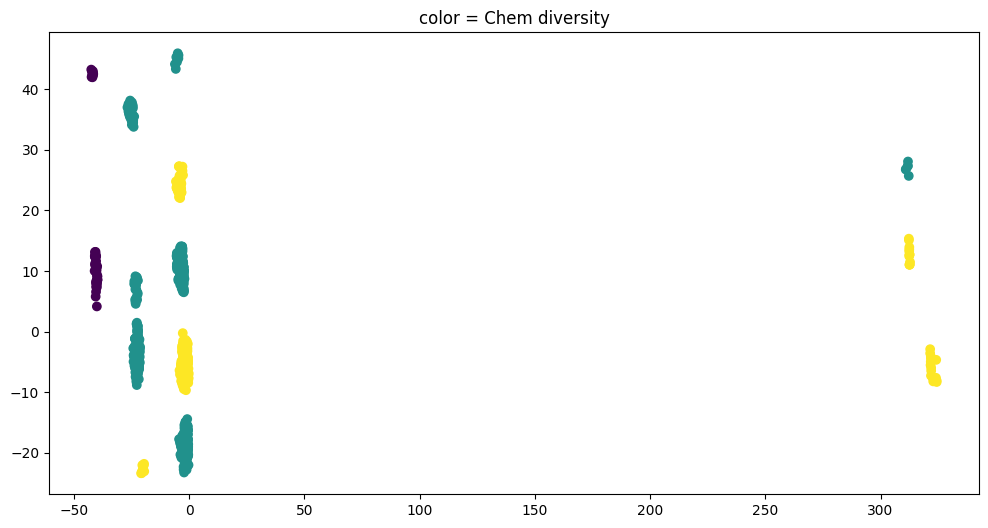

In [ ]:
max_Z = qm7_data['Z'].max(axis=1)
print (max_Z)
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=max_Z)
plt.title("color = Heaviest atom in molecule")
plt.show()

plt.scatter(X_reduced[:,0], X_reduced[:,1],c=qm7_data["T"])
plt.title("color = Atomization energy")
plt.show()

df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=df_u.nunique(axis=1))
plt.title("color = Chem diversity")
plt.show()

As you can see in the plots above, the first principle component seems to mainly encode information about the heaviest atom in the molecule. In order to further validate this information and to show another way of analyzing the principle components the qm7 dataset will be split into two parts according to the PC1 value (> 250 and < 50). Py3Dmol will be used in order to visualize the structures of the molecule. By looking at different structures from the two PC1 ranges one can see that the main difference between them is the presence or absence of sulfur atoms.

In [ ]:
df_pca_cm = pd.DataFrame(X_reduced)
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()

# Change the number in the rectangular bracets below to check different structures
# Change idx_smallest_pc1 to idx_largest_pc1 in order to check the other PC1 range
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_smallest_pc1[5], s)
mol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## With data standardization

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

In [ ]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(qm7_cm))
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,-0.044549,0.722757,-0.483804,-0.465096,-1.047523,-1.275253,-1.402952,-0.467348,-0.102323,-0.025052,...,-1.369330,-2.136465,1.770912,1.724548,-0.346133,-0.170830,1.859144,-0.852049,0.988651,0.0
1,-0.044549,0.725228,-0.476380,0.906262,-1.037807,-1.803589,-1.410930,-0.434049,-0.137355,0.747407,...,-1.334562,-2.136684,1.809340,1.639142,-0.993904,-0.878766,1.846415,1.199059,-1.290658,0.0
2,-0.044549,0.728975,0.744357,-0.458203,-0.183195,-1.803703,-1.411218,0.059881,0.532819,0.029254,...,-1.242912,-2.067548,-0.727372,-0.649023,-0.956618,2.237051,-0.773411,1.185188,-1.295472,0.0
3,-0.044549,0.718454,-0.508503,0.906193,-0.171030,-1.805138,-1.523623,-0.526795,0.517558,0.034193,...,-1.323124,-2.150048,-0.077073,3.578688,-0.494582,2.250263,-0.400732,-0.825875,-1.096336,0.0
4,-0.723964,0.098569,-0.128764,-0.079294,-0.871444,-1.926379,-1.556895,-0.584487,-0.342716,-0.789746,...,-1.223060,-2.135624,-0.818050,-0.728077,2.983373,2.272133,-0.452575,-0.873451,-1.081588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,-0.418149,0.950632,0.624795,-0.689563,-0.426326,-0.183215,-0.412029,-0.852373,-0.831957,0.463348,...,0.419067,0.556566,-0.442788,-0.179744,-1.095523,-0.843277,0.821287,-1.042932,0.856048,0.0
1215,-0.418149,0.785287,0.626409,-0.664681,-0.305158,-0.210053,-0.270636,-0.890492,-0.761952,-0.728877,...,0.369628,0.535037,-0.336154,-0.653435,1.322095,0.983624,1.844822,1.194901,-1.267976,0.0
1216,-0.723964,-0.125038,-0.934655,0.006048,-0.689139,-0.593179,1.620175,-0.630176,-0.899804,-1.011699,...,-0.623292,0.559996,-0.193912,-0.538604,-0.795345,0.766032,-0.541173,-0.910498,0.847176,0.0
1217,-0.723964,-0.086327,-0.047584,-0.942256,-0.678343,0.985074,-0.047409,-1.102956,-1.064490,-0.284456,...,-0.542386,0.559233,0.961996,0.978596,-0.849560,-0.206499,1.688425,-0.832395,-1.078552,0.0


In [ ]:
pca = PCA(n_components=2)
pca.fit(df_scaled)

PCA(n_components=2)

In [ ]:
X_reduced = pca.transform(df_scaled)
X_reduced

array([[11.536645  , -4.4950776 ],
       [10.823504  , -4.39093   ],
       [11.393048  , -3.8253605 ],
       ...,
       [-0.32699203, -0.13322973],
       [-0.14465824, -3.0910618 ],
       [-0.57722723, -3.3237524 ]], dtype=float32)

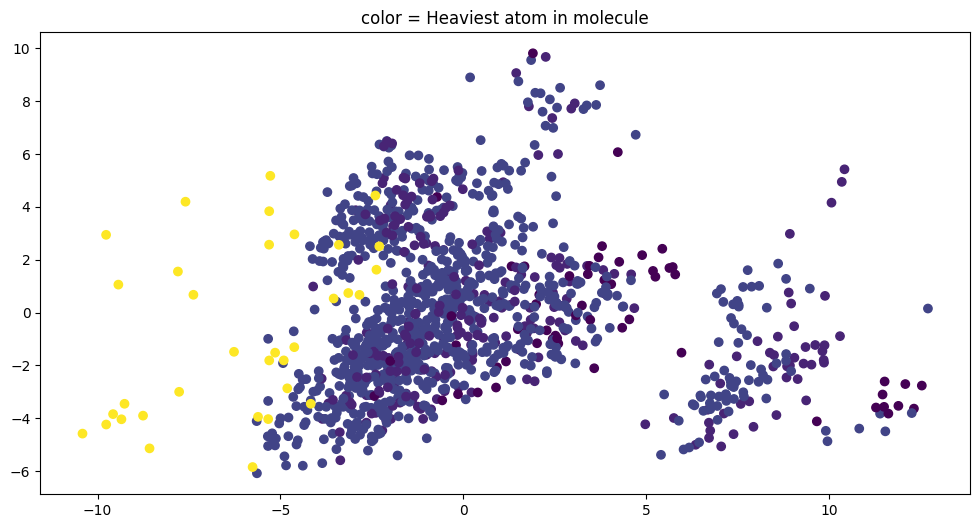

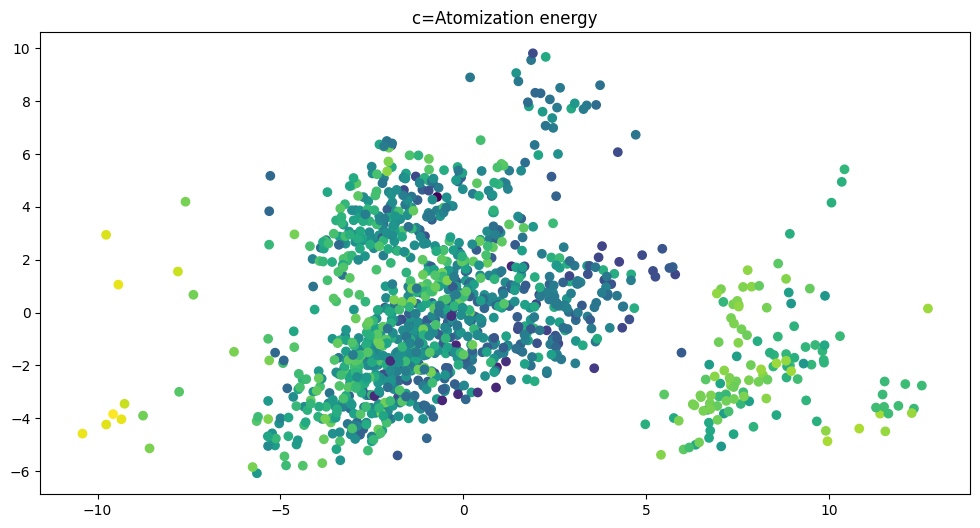

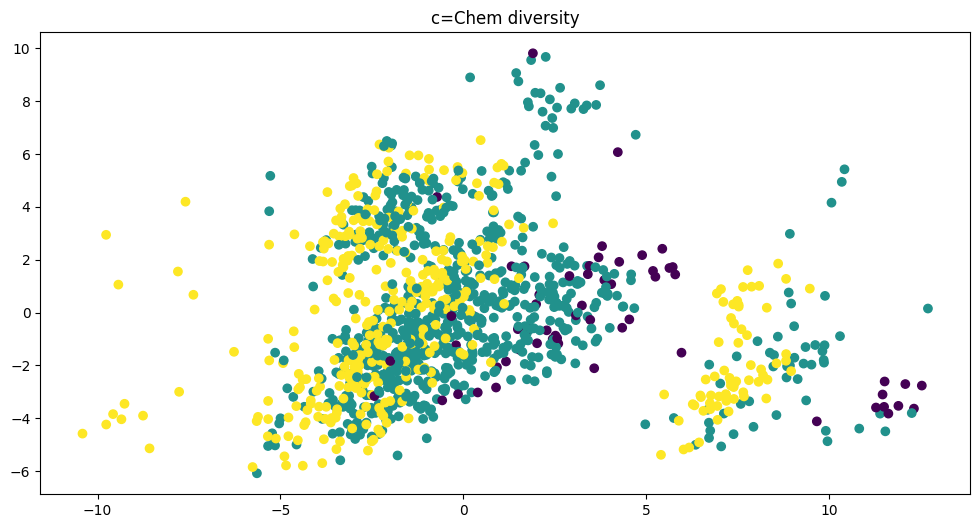

In [ ]:
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=max_Z)
plt.title("color = Heaviest atom in molecule")
plt.show()
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=qm7_data["T"])
plt.title("c=Atomization energy")
plt.show()

df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_reduced[:,0], X_reduced[:,1],c=df_u.nunique(axis=1))
plt.title("c=Chem diversity")
plt.show()


# Selecting number of principal components

Choosing the correct number of PC is vital to successfully reducing the dimensionality of your data. If the number of principle components is set to low not all of the variance in the data is accounted for, while too many principle components can be redundant. In order to evaluate how many PCs to choose the explained variance ratio for each principle component can be calculated and visualized. In the following section, PCA is performed for 5 PCs and visualized.

[0.06134314 0.04071224 0.03209443 0.03092562 0.02383894 0.0228561
 0.02063099 0.01952819]


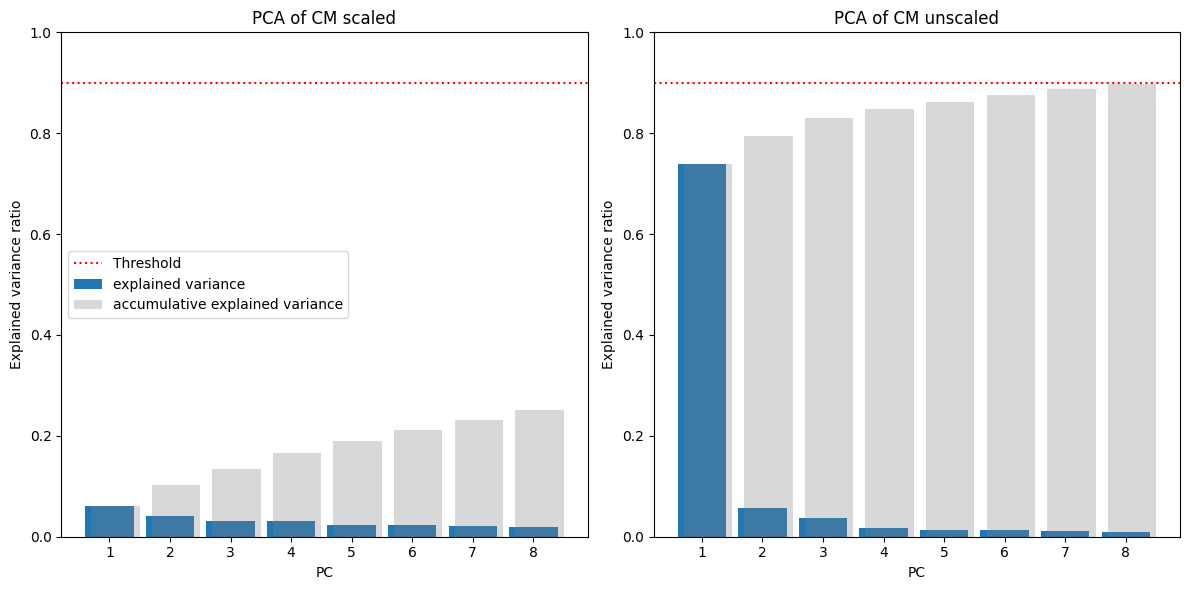

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1, 2, 1)
pca_scaled = PCA(n_components=8)
pca_scaled.fit(df_scaled)
X_new_scaled = pca_scaled.transform(df_scaled)
pcs_scaled = np.arange(len(pca_scaled.explained_variance_ratio_))+1
print (pca_scaled.explained_variance_ratio_)
s = 0
cumsum = [(s:=s+i) for i in pca_scaled.explained_variance_ratio_]
plt.bar(pcs_scaled, pca_scaled.explained_variance_ratio_,label="explained variance")
plt.bar(pcs_scaled+0.1, cumsum, color="gray", alpha = 0.3,label="accumulative explained variance")
plt.title("PCA of CM scaled")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.ylim(0,1)
plt.axhline(y = 0.9, color = 'r', linestyle = ':',label="Threshold")
plt.legend(loc="center left")

plt.subplot(1, 2, 2)
pca = PCA(n_components=8)
pca.fit(df_qm7_cm)
X_new = pca.transform(df_qm7_cm)
pcs = np.arange(len(pca.explained_variance_ratio_))+1
s = 0
cumsum = [(s:=s+i) for i in pca.explained_variance_ratio_]
plt.bar(pcs, pca.explained_variance_ratio_,label="explained variance")
plt.bar(pcs+0.1, cumsum, color="gray", alpha = 0.3,label="accumulative explained variance")
plt.title("PCA of CM unscaled")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.ylim(0,1)
#plt.legend(loc="center left")
plt.axhline(y = 0.9, color = 'r', linestyle = ':')


plt.tight_layout()


**Calculate the reconstruction error for the standardized and non-standardized datasets**

# Comparison of scaled vs. unscaled Coulomb matrix for PCA
As can be seen above the explained variance for the 8 first principle components is lower for the scaled Coulomb matrix than for the unscaled one. Althogh on the first glance the results from the PCA of the unscaled Coulomb matrix look more promising i.e. more variance explained with fewer principle components. Sadly this is missleading in this example.
    -> Take a closer look at the coulomb matrix and think about why normalization might be needed an why an unormalized Coulomb matrix leads to a seemingly "better PCA".
This example highlights why it is important to inspect the principle component (e.g. with plotting it according to different values, or visualizing a few molecules from one PC range).

# Interpreting principal components

In [ ]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
X_reduced = pca.transform(df_scaled)

In [ ]:
df_importance = pd.DataFrame(pca.components_)
df_importance = df_importance.apply(np.abs)
df_importance = df_importance.transpose()
df_importance.columns = ["PC1", "PC2"]
df_importance.head(5)

,PC1,PC2
0,0.091023,0.010973
1,0.048403,0.003754
2,0.037316,0.022188
3,0.080986,0.013596
4,0.072896,0.002989


In [ ]:
df_importance["PC1"].sort_values(ascending=False)

96     0.213252
97     0.198513
111    0.198513
126    0.182097
98     0.182097
         ...   
160    0.000000
144    0.000000
128    0.000000
64     0.000000
224    0.000000
Name: PC1, Length: 225, dtype: float32

## Visualizing the molecular structures

In [ ]:
df_pca_cm = pd.DataFrame(X_reduced)
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()

In [ ]:
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_largest_pc1[5], s)
mol

IndexError: ignored

In [ ]:
mol = view_molecule(qm7_data, idx_smallest_pc1[22], s)
mol


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
X_new[:,0].max()
df_X_new = pd.DataFrame(X_new)
plt.subplot(1, 2, 1)
df_X_new_filtered = df_X_new.loc[df_X_new[0] > 250]

test = pd.DataFrame(qm7_data['Z'][list(df_X_new_filtered.index.values)])
plt.hist(test.stack())
plt.xlabel("Z of atoms in molecules")
plt.ylabel("#")
plt.title("PC1 > 250")

plt.subplot(1, 2, 2)
df_X_new_filtered = df_X_new.loc[df_X_new[0] < 250]
test = pd.DataFrame(qm7_data['Z'][list(df_X_new_filtered.index.values)])
plt.hist(test.stack())
plt.ylabel("#")
plt.title("PC1 < 250")
plt.xlim(0,17)


To evaluate the seperation of molecules by the first principle component for the unscaled dataset the number of atoms for molecules showing a PC 1 of over or under 250 is plotted above. Molecules with a PC1 over 250 are made of Sulfur atoms (Z=16), whilst molecules with a PC1 under 250 are not.

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(df_scaled)

# Notice the longer calculation time
# How to determine the perplexity

plt.scatter(X_embedded.T[0],X_embedded.T[1])
plt.show()
plt.scatter(X_embedded.T[0],X_embedded.T[1],c=qm7_data["T"])
plt.title("c=Atomization energy")
plt.show()

df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_embedded.T[0],X_embedded.T[1],c=df_u.nunique(axis=1))
plt.title("c=Chem diversity")
plt.show()
